In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
class discrete:
    # Elementary signal definition
    #########################################
    
    # Kronecker impulsion
    def kronecker_imp(n):
        """Returns the kronecker delta signal which is 1 at n = 0 and 0 otherwise."""
        assert np.all(np.array(n, dtype=int) == n), 'kronecker_imp: n should be an integer or an array of integers.'
        return np.where(n == 0, 1, 0)
        
    # Unit jump
    def unit_jump(n):
        """Returns a unit jump signal where the signal is 1 for n >= 0 and 0 otherwise."""
        assert np.all(np.array(n, dtype=int) == n), 'unit_jump: n should be an integer or an array of integers.'
        return np.where(n >= 0, 1, 0)

    def causal_poly(n, N):
        """Returns the causal polynomial signal of degree N >= 1."""
        # Check input parameters
        assert np.all(np.array(n, dtype=int) == n), 'causal_poly: n should be an integer or an array of integers.'
        assert int(N) == N, 'causalpol: The provided polynomial degree is not an integer.'
        assert N >= 1, 'causalpol: The polynomial degree should be bigger than 0.'
        N = int(N)
        # Construct plynomial array where each row corresponds to an n value and each column corresponds to an N value
        A = np.zeros((len(n), N))
        A[:][n>=0] = np.linspace(1, N, N)
        A.T[:, n>=0] += n[n>=0]
        # Calculate product over rows and normalize
        return np.prod(A, axis=1) / np.math.factorial(N)
    
    # Rectangular signal
    def rect_signal(n, n1, n2):
        """Returns a rectangular signal with zeros everywhere except vor values n1 <= n <= n2."""
        assert np.all(np.array(n, dtype=int) == n), 'rect_signal: n should be an integer or an array of integers.'
        return np.where(np.logical_and(n>=n1, n<=n2), 1, 0)
        
    # Complex exponential
    def complex_exp(n, w0):
        """Calculates e^(j*w0*n)."""
        assert np.all(np.array(n, dtype=int) == n), 'complex_exp: n should be an integer or an array of integers.'
        assert type(w0) != complex, 'complex_exp: w0 should be a real number.'
        return np.exp(1j * w0 * n)
    
    # Cosine
    def cos(n, w0=1, degrees=False):
        """Calculates cos(n*w0). Set degrees=True if working with angles in degrees."""
        assert np.all(np.array(n, dtype=int) == n), 'cos: n should be an integer or an array of integers.'
        assert type(w0) != complex, 'cos: w0 should be a real number.'
        if degrees:
            n = n * np.pi / 180
        return np.cos(w0 * n)
    
    # Sine
    def sin(n, w0=1, degrees=False):
        """Calculates sin(n*w0). Set degrees=True if working with angles in degrees."""
        assert np.all(np.array(n, dtype=int) == n), 'sin: n should be an integer or an array of integers.'
        assert type(w0) != complex, 'sin: w0 should be a real number.'
        if degrees:
            n = n * np.pi / 180
        return np.sin(w0 * n)
    
    #Discrete signal transformations/operations
    ####################################################
    def check_n(h, n, func_name):
        if n is None or len(h) != len(n):
            warnings.warn(f'{func_name}: Length of n is not the same as h, assuming h starts at time 0.')
            return np.linspace(0, len(h)-1, len(h))
        else:
            assert np.all(np.array(n, dtype=int) == n), f'{func_name}: n should be an integer or an array of integers.'
        return n
    
    def convolve(f, g, mode='full'):
        """
        Calculates the convolution between f of length N and g of lenght M.
        Possible values for mode:
        * "full", it returns the convolution at each point of overlap, with an output shape of N+M-1. 
        * "same" returns output of length max(M, N).
        * "valid" returns output of length max(M, N) - min(M, N) + 1. The convolution product is only given for points where the signals overlap completely. 
        """
        return np.convolve(f, g, mode=mode)

    def convolve_circ(f, g):
        """Caclulates the circular convolution between f and g.
        The two signals must have the same length N and be N-periodic"""
        assert len(f)==len(g), 'convolve_circ: f and g should have the same length.'
        return np.real(np.fft.fftshift(np.fft.ifft( np.fft.fft(f)*np.fft.fft(g))))
    
    def z_transform(h, z, n=None):
        """Calculates the z transform of h[n] and evaluates it at values z."""
        # Checking input params
        n = discrete.check_n(h, n, 'z_transform')
        # Construct array of z^-n where each row corresponds to a z value and each column corresponds to a n value
        A = np.fromfunction(lambda i, j: z[i.astype(int)]**(-n[j.astype(int)]), shape=(len(z), len(n)))
        # Calculate sum over all n for each z
        return np.dot(A, h)
    
    def DTFT(h, w, n=None):
        """Calculates the DTFT of the signal h[n] and evaluates it at continuous frequency values w."""
        # Checking input params
        n = discrete.check_n(h, n, 'DTFT')
        # Construct array of e^-jwn where each row corresponds to a w value and each column corresponds to a n value
        A = np.fromfunction(lambda i, j: np.exp(-1j*w[i.astype(int)]*n[j.astype(int)]), shape=(len(w), len(n)))
        # Calculate sum over all n for each w
        return np.dot(A, h)

    def DFT(h, m, N=None):
        """Calculates the DFT of the signal h with period N and evaluates it at dicrete values m."""
        # Check input params
        assert np.all(np.array(m, dtype=int) == m), 'DFT: m should be an integer or an array of integers.'
        if N is None:
            warnings.warn('DFT: N not specified, assuming N is the length of h.')
            N = len(h)
        else:
            assert int(N)==N, 'DFT: N should be an integer number.'
        n = np.linspace(0, N-1, N)
        # Construct array of e^-jwn where each row corresponds to a w value and each column corresponds to a n value
        A = np.fromfunction(lambda i, j: np.exp(-1j*m[i.astype(int)]*2*np.pi*n[j.astype(int)]/N), shape=(len(m), N))
        # Calculate sum over all n (0 to N-1) for each m
        return np.dot(A, h[:N])
    
    def shift(h, k, periodic=False):
        """Shifts the signal h by k elements."""
        assert int(k)==k, 'shift: k should be an integer number.'
        out = np.zeros((len(h),))
        if k > 0:
            out[:-k] = h[k:]
            if periodic:
                out[-k:] = h[:k]
        else:
            out[-k:] = h[:k]
            if periodic:
                out[:-k] = h[k:]
        return out
    
    def downsample(h, M):
        """Downsamples the signal h by a factor M."""
        return h[::M]
    
    def upsample(h, M):
        """Upsamples the signal h by a factor M."""
        out = np.zeros((len(h)*M,))
        out[::M] = h
        return out
    
    def flip(h):
        """Flips the signal h in time. h[n] --> h[-n]."""
        return np.flip(h)
    
    def monome_mult(h, k, n=None):
        """Performs the monome multiplication of degree k with signal h[n]."""
        # Checking input params
        assert type(k) != complex, 'monome_mult: k should be a positive integer.'
        assert int(k) == k, 'monome_mult: k should be a positive integer.'
        assert k > 0, 'monome_mult: k should be a positive integer.'
        n = discrete.check_n(h, n, 'monome_mult')
        return n**k * h
    
    def DTFT_modulation(h, w0, n=None):
        """Modulates the signal h[n] with complex exponentials e^(j*w0*n)."""
        # Checking input params
        assert type(w0) != complex, 'DTFT_modulation: w0 should be a positive integer.'
        assert int(w0) == w0, 'DTFT_modulation: w0 should be a positive integer.'
        assert w0 > 0, 'DTFT_modulation: w0 should be a positive integer.'
        n = discrete.check_n(h, n, 'DTFT_modulation')
        return np.exp(1j*w0*n) * h
    
    def DFT_modulation(h, m0, n=None, N=None):
        """Modulates the signal h[n] with complex exponentials e^(j*m0*2π/N*n)."""
        # Checking input params
        assert type(m0) != complex, 'DFT_modulation: m0 should be a positive integer.'
        assert int(m0) == m0, 'DFT_modulation: m0 should be a positive integer.'
        assert m0 > 0, 'DFT_modulation: m0 should be a positive integer.'
        n = discrete.check_n(h, n, 'DFT_modulation')
        if N is None:
            warnings.warn('DFT_modulation: N not specified, assuming N is the length of h.')
            N = len(h)
        else:
            assert int(N)==N, 'DFT_modulation: N should be an integer number.'
        return np.exp(1j*m0*2*np.pi*n/N) * h

In [3]:
class continuous:
    # Elementary signal definition
    #########################################
    
    # Kronecker impulsion
    def kronecker_imp(t):
        """Returns the kronecker delta signal which is 1 at t = 0 and 0 otherwise."""
        return np.where(t == 0, 1, 0)
        
    # Unit jump
    def unit_jump(t):
        """Returns a unit jump signal where the signal is 1 for t >= 0 and 0 otherwise."""
        return np.where(t >= 0, 1, 0)

    def causal_poly(t, N):
        """Returns the causal polynomial signal of degree N >= 1."""
        # Check input parameters
        assert int(N) == N, 'causalpol: The provided polynomial degree is not an integer.'
        assert N >= 1, 'causalpol: The polynomial degree should be bigger than 0.'
        N = int(N)
        # Construct plynomial array where each row corresponds to a t value and each column corresponds to an N value
        A = np.zeros((len(t), N))
        A[:][t>=0] = np.linspace(1, N, N)
        A.T[:, t>=0] += t[t>=0]
        # Calculate product over rows and normalize
        return np.prod(A, axis=1) / np.math.factorial(N)
    
    # Rectangular signal
    def rect_signal(t, t1, t2):
        """Returns a rectangular signal with zeros everywhere except vor values n1 <= n <= n2."""
        return np.where(np.logical_and(t>=t1, t<=t2), 1, 0)
        
    # Complex exponential
    def complex_exp(t, w0):
        """Calculates e^(j*w0*t)."""
        assert type(w0) != complex, 'complex_exp: w0 should be a real number.'
        return np.exp(1j * w0 * t)
    
    # Cosine
    def cos(t, w0=1, degrees=False):
        """Calculates cos(t*w0). Set degrees=True if working with angles in degrees."""
        assert type(w0) != complex, 'cos: w0 should be a real number.'
        if degrees:
            t = t * np.pi / 180
        return np.cos(w0 * t)
    
    # Sine
    def sin(n, w0=1, degrees=False):
        """Calculates sin(t*w0). Set degrees=True if working with angles in degrees."""
        assert type(w0) != complex, 'sin: w0 should be a real number.'
        if degrees:
            t = t * np.pi / 180
        return np.sin(w0 * t)
    
    #Discrete signal transformations/operations
    ####################################################
    def check_t(h, t, func_name):
        if t is None or len(h) != len(n):
            warnings.warn(f'{func_name}: Length of t is not the same as h, assuming h starts at time 0 and dt=0.1.')
            return np.linspace(0, (len(h)-1)*0.1, len(h))
        return t
    
    def convolve(f, g, mode='full'):
        """
        Calculates the convolution between f of length N and g of lenght M.
        Possible values for mode:
        * "full", it returns the convolution at each point of overlap, with an output shape of N+M-1. 
        * "same" returns output of length max(M, N).
        * "valid" returns output of length max(M, N) - min(M, N) + 1. The convolution product is only given for points where the signals overlap completely. 
        """
        return np.convolve(f, g, mode=mode)

    def convolve_circ(f, g):
        """Caclulates the circular convolution between f and g.
        The two signals must have the same length N and be N-periodic"""
        assert len(f)==len(g), 'convolve_circ: f and g should have the same length.'
        return np.real(np.fft.fftshift(np.fft.ifft( np.fft.fft(f)*np.fft.fft(g))))
    
    def FT(h, w, t=None):
        """Calculates the Fourier Transform of the signal h(t) and evaluates it at frequency values w."""
        # Checking input params
        t = discrete.check_n(h, t, 'FT')
        # Construct array of e^-jwn where each row corresponds to a w value and each column corresponds to a n value
        A = np.fromfunction(lambda i, j: np.exp(-1j*w[i.astype(int)]*t[j.astype(int)]), shape=(len(w), len(t)))
        # Calculate sum over all n for each w
        return np.dot(A, h)
    
    def shift(h, k, dt=None, t=None, periodic=False):
        """Shifts the signal h by k. 
        If dt is provided, k will be interpreted as a time shift.
        If t is provided, dt will be calculated as (max(t)-min(t))/len(t)
        Otherwise k will be interpreted as an index shift.
        """
        out = np.zeros((len(h),))
        if dt is None:
            if t is not None:
                dt = (max(t)-min(t))/len(t)
            else:
                dt = 1
        k = int(k/dt)
        if k > 0:
            out[:-k] = h[k:]
            if periodic:
                out[-k:] = h[:k]
        else:
            out[-k:] = h[:k]
            if periodic:
                out[:-k] = h[k:]
        return out

    def flip(h):
        """Flips the signal h in time. h(t) --> h(-t)."""
        return np.flip(h)
    
    def monome_mult(h, k, t=None):
        """Performs the monome multiplication of degree k with signal h(t)."""
        # Checking input params
        assert type(k) != complex, 'monome_mult: k should be a positive integer.'
        assert int(k) == k, 'monome_mult: k should be a positive integer.'
        assert k > 0, 'monome_mult: k should be a positive integer.'
        n = discrete.check_t(h, t, 'monome_mult')
        return t**k * h
    
    def FT_modulation(h, w0, t=None):
        """Modulates the signal h(t) with complex exponentials e^(j*w0*t)."""
        # Checking input params
        assert type(w0) != complex, 'DTFT_modulation: w0 should be a positive integer.'
        assert int(w0) == w0, 'DTFT_modulation: w0 should be a positive integer.'
        assert w0 > 0, 'DTFT_modulation: w0 should be a positive integer.'
        t = discrete.check_t(h, t, 'DTFT_modulation')
        return np.exp(1j*w0*t) * h
    
    def dilate(h, d, t):
        """Dilates the signal h by a factor d. f(t) --> f(t/d)."""
        pass
        

In [26]:
help(discrete.convolve)

Help on function convolve in module __main__:

convolve(f, g, mode='full')
    Calculates the convolution between f of length N and g of lenght M.
    Possible values for mode:
    * "full", it returns the convolution at each point of overlap, with an output shape of N+M-1. 
    * "same" returns output of length max(M, N).
    * "valid" returns output of length max(M, N) - min(M, N) + 1. The convolution product is only given for points where the signals overlap completely.



In [23]:
#m = np.linspace(0, 49, 50)
n = np.linspace(-20, 20, 41)
h = discrete.unit_jump(n)
sig = discrete.shift(h, -7)

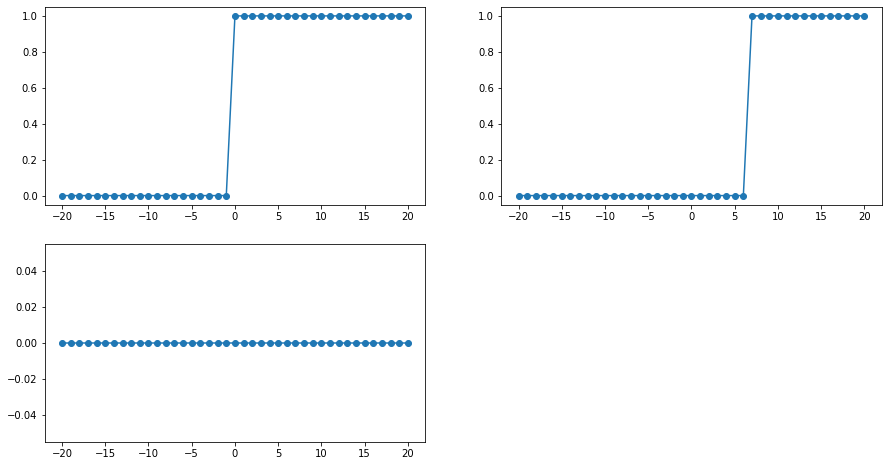

In [25]:
plt.close('all')
plt.figure(figsize=(15, 8))
plt.subplot(221)
plt.plot(n, h, '-o')
plt.subplot(222)
plt.plot(n, sig.real, '-o')
plt.subplot(223)
plt.plot(n, sig.imag, '-o')
# plt.subplot(224)
plt.show()